In [1]:
# =======================
# IMPORTS
# =======================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import random

In [2]:
# =======================
# CONFIGURATIONS
# =======================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 15
TFLITE_PATH = "model.tflite"
SEED = 42
LOSS_FUNCTION = 'focal'  # 'binary_crossentropy' or 'focal'
ARCHITECTURE = 'CNN'     # 'MobileNetV2', 'EfficientNetB0', 'ResNet50', 'VGG16', 'CNN'
ACTIVATION = 'leaky_relu' # 'relu', 'leaky_relu', 'elu'
OPTIMIZER = 'rmsprop'    # 'adam', 'sgd', 'rmsprop'
THRESHOLD = 0.4  # Custom threshold for evaluation

# Set seeds
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Paths
train_path = r"C:\Users\Adars\Desktop\dataset\train"
test_path = r"C:\Users\Adars\Desktop\dataset\test"


In [3]:
# =======================
# FUNCTIONS
# =======================
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        cross_entropy = -K.log(p_t)
        loss = alpha_factor * K.pow(1 - p_t, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fn

def get_activation_function(name):
    if name == 'relu': return tf.keras.layers.ReLU()
    elif name == 'leaky_relu': return LeakyReLU(alpha=0.3)
    elif name == 'elu': return tf.keras.layers.ELU()
    else: return tf.keras.layers.ReLU()

def get_optimizer(name):
    if name == 'adam': return tf.keras.optimizers.Adam(learning_rate=1e-4)
    elif name == 'sgd': return tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
    elif name == 'rmsprop': return tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    else: return tf.keras.optimizers.Adam(learning_rate=1e-4)

def build_model(architecture, activation_fn):
    if architecture == 'MobileNetV2':
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'EfficientNetB0':
        base_model = EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'ResNet50':
        base_model = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'VGG16':
        base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    elif architecture == 'CNN':
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            Flatten(),
            Dense(256),
            activation_fn,
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        return model
    else:
        raise ValueError(f"Invalid architecture: {architecture}")

    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128),
        activation_fn,
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=SEED
    )

    val_gen = train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=SEED
    )

    test_gen = test_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: 1.0, 1: 1.0}


c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Adars\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 335ms/step - accuracy: 0.6247 - loss: 0.0581 - precision: 0.7924 - recall: 0.2718 - val_accuracy: 0.5967 - val_loss: 0.0581 - val_precision: 0.8919 - val_recall: 0.2200 - learning_rate: 1.0000e-04
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 353ms/step - accuracy: 0.8098 - loss: 0.0389 - precision: 0.9411 - recall: 0.6523 - val_accuracy: 0.6192 - val_loss: 0.0564 - val_precision: 0.9799 - val_recall: 0.2433 - learning_rate: 1.0000e-04
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 386ms/step - accuracy: 0.8510 - loss: 0.0325 - precision: 0.9535 - recall: 0.7345 - val_accuracy: 0.7058 - val_loss: 0.0464 - val_precision: 0.9732 - val_recall: 0.4233 - learning_rate: 1.0000e-04
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 115s 383ms/step - accuracy: 0.8674 - loss: 0.0286 - precision: 0.9630 - recall: 0.7596 - val_accuracy: 0.7617 - val_loss: 0.0406 - val_precision: 0.9673 - val_recall: 0.5417 - learning_rate: 1.0000e-04
Epoch 5/15
300/300 ━━━━━━━━━━━━━

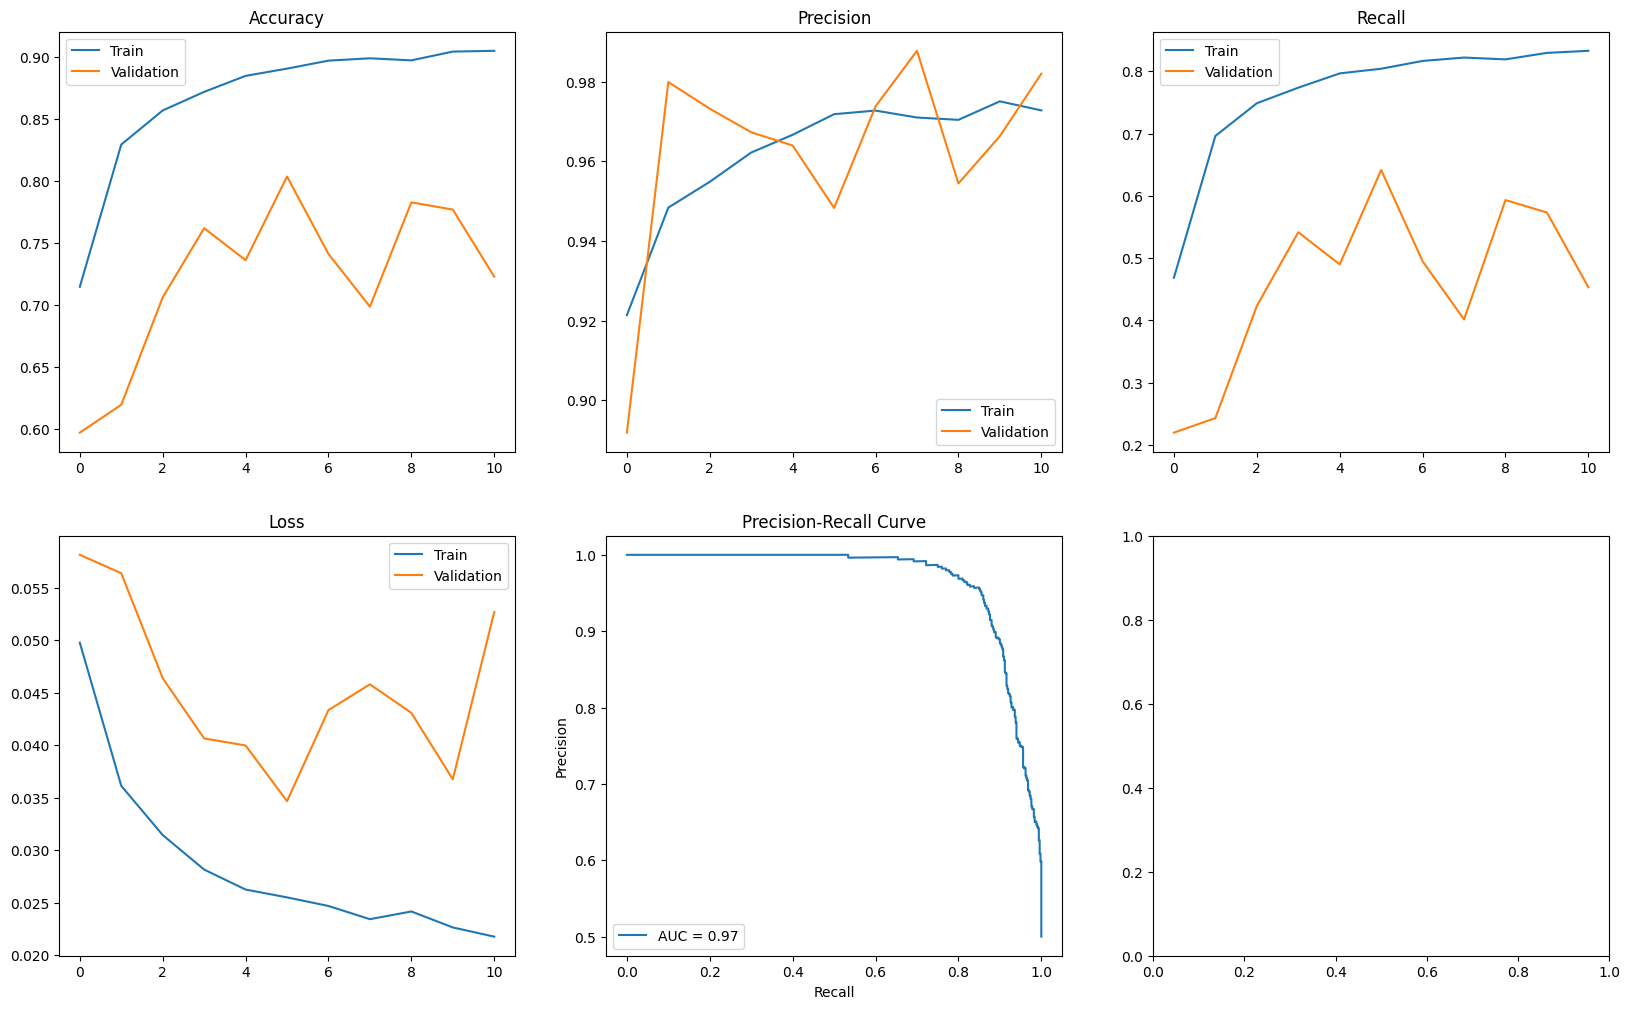

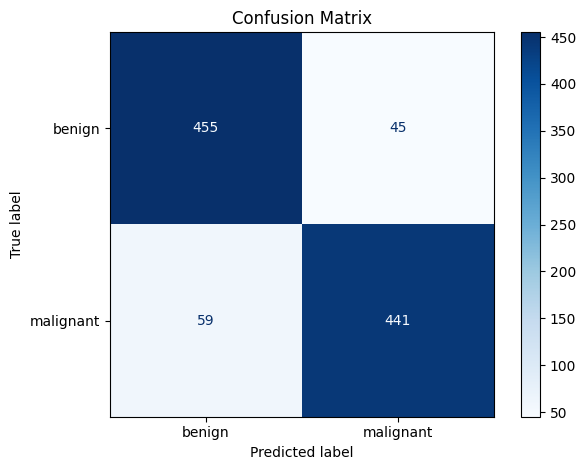

INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmpi4xwlfy6\assets


INFO:tensorflow:Assets written to: C:\Users\Adars\AppData\Local\Temp\tmpi4xwlfy6\assets


Saved artifact at 'C:\Users\Adars\AppData\Local\Temp\tmpi4xwlfy6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2365930366832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365930359792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365927017456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365927025904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025457280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025456752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025456928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025465376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025623936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2366025623408: TensorSpec(shape=(), dtype=tf.resource, name=None)

TFLite 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,489,860 (169.72 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,244,931 (84.86 MB)

In [4]:
# =======================
# TRAINING & EVALUATION
# =======================
if __name__ == "__main__":
    train_gen, val_gen, test_gen = create_data_generators()

    model = build_model(ARCHITECTURE, get_activation_function(ACTIVATION))

    loss = focal_loss() if LOSS_FUNCTION == 'focal' else 'binary_crossentropy'
    custom_objects = {'focal_loss_fn': focal_loss(), 'LeakyReLU': LeakyReLU}

    # Compute class weights
    labels = train_gen.classes
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class Weights: {class_weight_dict}")

    model.compile(
        optimizer=get_optimizer(OPTIMIZER),
        loss=loss,
        metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')]
    )

    callbacks = [
        EarlyStopping(monitor='val_recall', patience=5, mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]

    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )

    model = tf.keras.models.load_model('best_model.keras', custom_objects=custom_objects)
    test_results = model.evaluate(test_gen)
    print(f"\nTest Metrics:\nLoss: {test_results[0]:.4f}\nAccuracy: {test_results[1]:.4f}\nRecall: {test_results[2]:.4f}\nPrecision: {test_results[3]:.4f}")

    # Visualization
    plt.figure(figsize=(20, 12))
    plt.subplot(2, 3, 1); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Validation'); plt.title('Accuracy'); plt.legend()
    plt.subplot(2, 3, 2); plt.plot(history.history['precision'], label='Train'); plt.plot(history.history['val_precision'], label='Validation'); plt.title('Precision'); plt.legend()
    plt.subplot(2, 3, 3); plt.plot(history.history['recall'], label='Train'); plt.plot(history.history['val_recall'], label='Validation'); plt.title('Recall'); plt.legend()
    plt.subplot(2, 3, 4); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Validation'); plt.title('Loss'); plt.legend()

    # Precision-Recall Curve and Confusion Matrix
    plt.subplot(2, 3, 5)
    y_probs = model.predict(test_gen)
    precision, recall, _ = precision_recall_curve(test_gen.classes, y_probs)
    plt.plot(recall, precision, label=f'AUC = {auc(recall, precision):.2f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()

    plt.subplot(2, 3, 6)
    y_pred = (y_probs > THRESHOLD).astype(int)
    cm = confusion_matrix(test_gen.classes, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=test_gen.class_indices.keys()).plot(cmap='Blues')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

    # TFLite Conversion with float16 quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_model = converter.convert()

    with open(TFLITE_PATH, 'wb') as f:
        f.write(tflite_model)

    print(f"\nTFLite model saved to: {TFLITE_PATH}")
    model.summary()
